## Defining base classes

In [1]:
from typing import NamedTuple, Literal, Union
from search_utils import AbstractNode

Position = Literal["east", "west"]


class State(NamedTuple):
    farmer: Position
    wolf: Position
    duck: Position
    corn: Position

    def __repr__(self) -> str:
        return f"State(farmer={self.farmer}, wolf={self.wolf}, duck={self.duck}, corn={self.corn})"

    def __str__(self) -> str:
        return self.__repr__()

    def __eq__(self, other: object) -> bool:
        if not isinstance(other, State):
            return False

        return (
            self.farmer == other.farmer
            and self.wolf == other.wolf
            and self.duck == other.duck
            and self.corn == other.corn
        )

    def copy_with(self, **kwargs) -> "State":
        r"""A copy constructor that returns a new state with the given attributes updated."""
        return State(**{**self._asdict(), **kwargs})

    @property
    def is_valid(self) -> bool:
        r"""The state is valid if the duck is not left alone with the corn while the farmer is not present,
        and the wolf is not left alone with the duck while the farmer is not present.
        """
        return not (
            (self.duck == self.corn and self.duck != self.farmer)
            or (self.wolf == self.duck and self.wolf != self.farmer)
        )


class Node(AbstractNode[State]):
    def __init__(self, action: str, state: State, parent: Union[State, None] = None):
        super().__init__(action, state, parent)

    def __eq__(self, other: object) -> bool:
        if not isinstance(other, Node):
            return False

        return self.state == other.state

    def __hash__(self) -> int:
        return super().__hash__()

## Candidate actions generator

In [2]:
CandidateAction = tuple[str, State]


def create_candidates(previous_state: State) -> list[CandidateAction]:
    candidates: list[CandidateAction] = [
        # Farmer with duck
        (
            "Farmer takes duck to west",
            previous_state.copy_with(farmer="west", duck="west"),
        ),
        (
            "Farmer takes duck to east",
            previous_state.copy_with(farmer="east", duck="east"),
        ),
        # Farmer with wolf
        (
            "Farmer takes wolf to west",
            previous_state.copy_with(farmer="west", wolf="west"),
        ),
        (
            "Farmer takes wolf to east",
            previous_state.copy_with(farmer="east", wolf="east"),
        ),
        # Farmer with corn
        (
            "Farmer takes corn to west",
            previous_state.copy_with(farmer="west", corn="west"),
        ),
        (
            "Farmer takes corn to east",
            previous_state.copy_with(farmer="east", corn="east"),
        ),
        # Farmer alone
        ("Farmer takes nothing to west", previous_state.copy_with(farmer="west")),
        ("Farmer takes nothing to east", previous_state.copy_with(farmer="east")),
    ]

    return candidates

In [3]:
from search_utils import StackFrontier, QueueFrontier, reconstruct_path


class FarmerProblem:
    def __init__(self, initial_state: State, goal: State) -> None:
        self.initial_state = initial_state
        self.goal = goal
        self.solution: list[Node] = []

    def neighbors(self, node: Node):
        """Generates the neighbors of a given node's state"""
        candidates = create_candidates(node.state)
        neighbors: list[Node] = []

        for action, state in candidates:
            if state.is_valid:
                neighbors.append(Node(action=action, state=state, parent=node))

        return neighbors

    def solve(self, frontier_type: Literal["stack", "queue"] = "stack"):
        num_explored = 0
        explored = set()

        frontier = (
            StackFrontier[State]()
            if frontier_type == "stack"
            else QueueFrontier[State]()
        )

        frontier.add(Node("Initial state", self.initial_state))

        while True:
            if frontier.is_empty:
                raise Exception("No solution, frontier is empty")

            current_node = frontier.remove()
            num_explored += 1
            print(f"Iteration n°{num_explored} - Action: {current_node.action}\n")

            if current_node.state == self.goal:
                return reconstruct_path(current_node), num_explored

            explored.add(current_node.state)
            for neighbor in self.neighbors(current_node):
                if neighbor.state not in explored and neighbor.state not in frontier:
                    frontier.add(neighbor)

In [4]:
# the initial bank from which the farmer starts
bank: Position = "west"
goal_bank: Position = "east"
initial_state = State(farmer=bank, wolf=bank, duck=bank, corn=bank)
goal_state = State(farmer=goal_bank, wolf=goal_bank, duck=goal_bank, corn=goal_bank)

In [5]:
problem = FarmerProblem(initial_state, goal_state)
solution_path, num_explored = problem.solve(frontier_type="stack")

Iteration n°1 - Action: Initial state

Iteration n°2 - Action: Farmer takes duck to east

Iteration n°3 - Action: Farmer takes nothing to west

Iteration n°4 - Action: Farmer takes corn to east

Iteration n°5 - Action: Farmer takes wolf to east



In [6]:
Node(
    action="fds",
    state=State(farmer="west", wolf="west", duck="west", corn="west"),
    parent=State(farmer="west", wolf="west", duck="west", corn="west"),
)

Node(action=fds, state=State(farmer=west, wolf=west, duck=west, corn=west), parent=State(farmer=west, wolf=west, duck=west, corn=west))

In [7]:
[node.action for node in solution_path]

['Initial state',
 'Farmer takes duck to east',
 'Farmer takes nothing to west',
 'Farmer takes corn to east',
 'Farmer takes wolf to east']

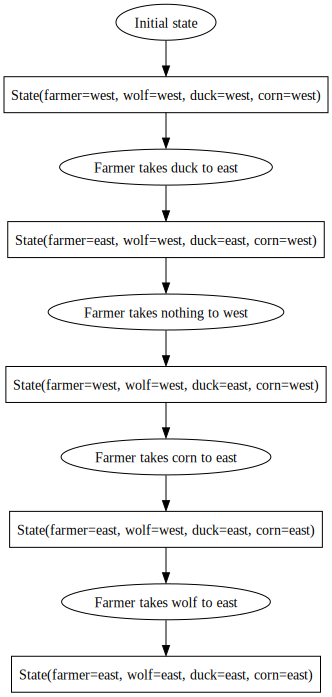

In [8]:
from search_utils import draw_path

draw_path(solution_path[-1])